# Group assignment

We investigate data on airfoil designs for aircraft. An airfoil is a the shape of a blade, wing or blade (of a turbine, propeller, rotor).
The data is on self-generated noise of an airfoil blade encountering smooth flow. A series of aerodynamic and acoustic tests were conducted in an anechoic wind tunnel on two- and three-dimensional airfoil blade sections. 
The self-noise is produced when the airfoil blade interacts with the turbulence produced by its boundary layer and its wake over nonturbulent inflow. The experiment studies how noise mechanisms affect operation of the airfoil. 

The data is in the file `airfoil-selfnoise.dat`. The data is from 7 NACA 0012 airfoil blade sections of different sizes (chord lengths from 2.5 to 61 cms) tested at wind tunnel speeds up to Mach 0.21 (Reynold's number based on chord up to $3 \times 10^6$) and at angles of attack from 0° to 22.2°.

So the following information is contained in the file:

    1. Frequency, in Hertzs.
    2. Angle of attack, in degrees.
    3. Chord length, in meters.
    4. Free-stream velocity, in meters per second.
    5. Suction side displacement thickness, in meters.

The target variable:

    6. Scaled sound pressure level, in decibels. 

We'll be investigating how different features interact with sound pressure. As usual, we'll generate summary statistics, visualize data, determining relationships in the data. We'll also apply a simple regression model to predict the sound pressure.

# Explore and visualize the data

We'll use the following online source to help us start on exploring the dataset. 
[Predicting airfoil self-noise using wind tunnel data and machine learning](http://www.datasciencedude.com/2015/05/31/test/). 

#### Import the necessary libraries for data manipulation and visualization; then load the data into a dataframe. Investigate the types of the variables, i.e., are the variables numeric or categoric?

In [228]:
%cd C:\Users\Teboho\Desktop\ALU\HLT Assignment_Int2
file_path = 'airfoil_self_noise.dat'

C:\Users\Teboho\Desktop\ALU\HLT Assignment_Int2


In [229]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import cm as cm

In [230]:
%matplotlib inline

In [231]:
df = pd.read_csv(file_path, sep = '\t')

In [232]:
df.head()

,800,0,0.3048,71.3,0.00266337,126.201
0,1000,0.0,0.3048,71.3,0.002663,125.201
1,1250,0.0,0.3048,71.3,0.002663,125.951
2,1600,0.0,0.3048,71.3,0.002663,127.591
3,2000,0.0,0.3048,71.3,0.002663,127.461
4,2500,0.0,0.3048,71.3,0.002663,125.571


In [233]:
df.columns = ['Frequency','Angle','Chord Length','Free-Stream Velocity','Displacement','Sound Pressure Level']

In [234]:
df.head()

,Frequency,Angle,Chord Length,Free-Stream Velocity,Displacement,Sound Pressure Level
0,1000,0.0,0.3048,71.3,0.002663,125.201
1,1250,0.0,0.3048,71.3,0.002663,125.951
2,1600,0.0,0.3048,71.3,0.002663,127.591
3,2000,0.0,0.3048,71.3,0.002663,127.461
4,2500,0.0,0.3048,71.3,0.002663,125.571


In [235]:
df.describe()

,Frequency,Angle,Chord Length,Free-Stream Velocity,Displacement,Sound Pressure Level
count,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000
mean,2887.769640,6.786818,0.136436,50.847137,0.011146,124.835034
std,3153.162983,5.917509,0.093471,15.569029,0.013153,6.900864
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.190000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.719000
75%,4000.000000,9.900000,0.228600,71.300000,0.015840,129.997750
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [236]:
df.isnull().sum()

Frequency               0
Angle                   0
Chord Length            0
Free-Stream Velocity    0
Displacement            0
Sound Pressure Level    0
dtype: int64

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
Frequency               1502 non-null int64
Angle                   1502 non-null float64
Chord Length            1502 non-null float64
Free-Stream Velocity    1502 non-null float64
Displacement            1502 non-null float64
Sound Pressure Level    1502 non-null float64
dtypes: float64(5), int64(1)
memory usage: 70.5 KB


In [238]:
df.shape

(1502, 6)

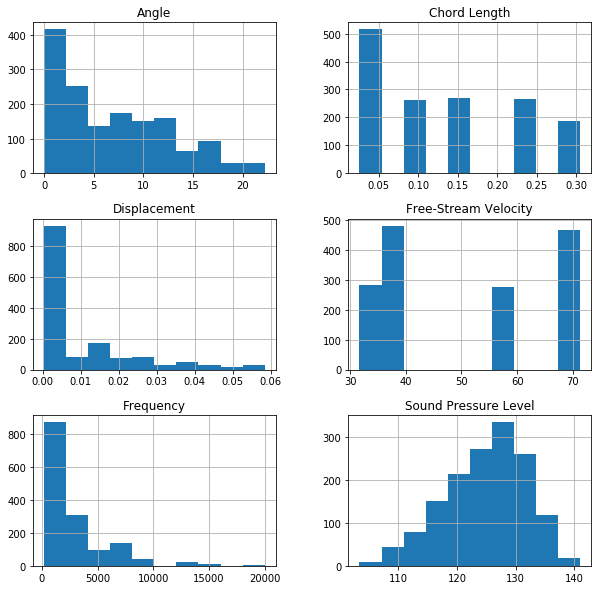

In [239]:
df.hist(figsize = (10,10));

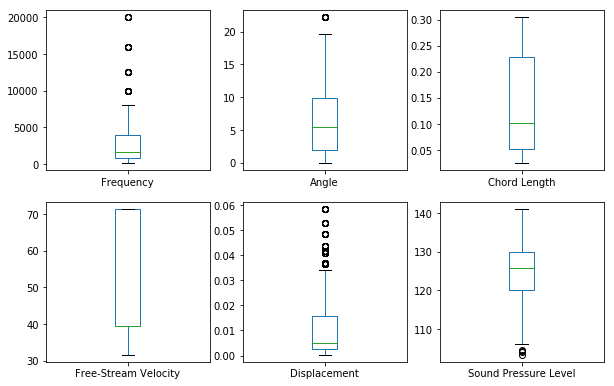

In [240]:
df.plot(kind = 'box', subplots = True, layout = (3,3), figsize = (10,10));

### Feature engineering

Feature engineering is a way to create new features using features already in the dataset. Here we're going to combine two features in the datset with a deterministic relationship between them. We're going to create something called Reynolds number.

#### The case of Reynolds number

Two features in the dataset, namely free stream velocity (m/s) and chord length (m), can be used to determine something called Reynolds number. According to [Wikipedia](https://en.wikipedia.org/wiki/Reynolds_number), Reynolds number, a dimensionaless quantity, is the ratio of internal forces to viscous forces within fluids, like air or water. This experiment is about the dynamics of air flow over an airfoil. Suffice to say, Reynolds number determines different flow patterns in different flow situations. Reynolds number for the chord length $Re$ is calculated as

$$Re = (\text{free stream velocity}) * (\dfrac{\text{chord length}}{\text{kinematic viscosity}}).$$ The kinematic viscousity for air at $27^{\circ}$ is $1.568 \times 10^{-5}$. [Wikipedia says](https://en.wikipedia.org/wiki/Reynolds_number) that "at low Reynolds numbers flow tends to be sheet-like, while at high Reynolds numbers turbulence occurs due to differences in the fluid's speed and direction, which may sometimes intersect or even move counter to the overall direction of the flow".

#### Let's use this information to create a new variable called $Re$ in our dataframe. Check to see that the Reynolds numbers are not greater than $3 \times 10^6$.

In [241]:
result = []
kinematic_visc = 0.00001568
for index, row in df.iterrows():
    new = row['Free-Stream Velocity']*(row['Chord Length']/kinematic_visc)
    result.append(new)
df['Re'] = result

In [242]:
df.head()

,Frequency,Angle,Chord Length,Free-Stream Velocity,Displacement,Sound Pressure Level,Re
0,1000,0.0,0.3048,71.3,0.002663,125.201,1.385985e+06
1,1250,0.0,0.3048,71.3,0.002663,125.951,1.385985e+06
2,1600,0.0,0.3048,71.3,0.002663,127.591,1.385985e+06
3,2000,0.0,0.3048,71.3,0.002663,127.461,1.385985e+06
4,2500,0.0,0.3048,71.3,0.002663,125.571,1.385985e+06


## Some visualizations

What can we learn from the data? What are the relationships between the features? What is the relationship between frequency and noise, for instance? Let's plot frequency against noise for different angles. Use the groupby to determine how many angles and their values. Recall that groupby returns a dictionary who's keys are the column used to group by.

#### Consider the frequency and noise level, how they interact. For each angle of attack, plot the frequency against noise levels.  And for each Reynolds number, plot frequency against noise levels. Discuss your observations.

In [243]:
mean_angles = df.groupby(df['Angle']).mean()
mean_reynolds = df.groupby(df['Re']).mean()

In [244]:
mean_angles.head()

,Frequency,Angle,Chord Length,Free-Stream Velocity,Displacement,Sound Pressure Level,Re
Angle,,,,,,,
0.0,4322.606707,0.0,0.153484,49.042073,0.001728,126.502375,4.768530e+05
1.5,4324.032258,1.5,0.304800,53.916129,0.003671,120.235000,1.048064e+06
2.0,2413.392857,2.0,0.228600,49.807143,0.003310,124.155571,7.261424e+05
2.7,4465.333333,2.7,0.152400,55.450000,0.002693,123.587167,5.389401e+05
3.0,2731.355932,3.0,0.304800,49.827119,0.004750,122.373339,9.685782e+05


In [245]:
mean_reynolds.head()

,Frequency,Angle,Chord Length,Free-Stream Velocity,Displacement,Sound Pressure Level
Re,,,,,,
51350.765306,2868.771930,8.340351,0.0254,31.7,0.006256,127.938263
64147.959184,2756.363636,11.694318,0.0254,39.6,0.010371,126.200716
89904.336735,4606.250000,8.836538,0.0254,55.5,0.006469,126.712173
102701.530612,2645.625000,8.470000,0.0508,31.7,0.013455,124.613150
115498.724490,4051.419753,12.370370,0.0254,71.3,0.010639,127.458605


In [246]:
frequency = df['Frequency'].groupby(df['Angle'])
noise = df['Sound Pressure Level'].groupby(df['Angle'])

In [247]:
frequency.describe()

,count,mean,std,min,25%,50%,75%,max
Angle,,,,,,,,
0.0,328.0,4322.606707,4104.747269,200.0,1250.0,2825.0,6300.0,20000.0
1.5,31.0,4324.032258,4207.300088,315.0,1125.0,2500.0,6300.0,16000.0
2.0,56.0,2413.392857,2206.420406,315.0,757.5,1600.0,3362.5,10000.0
2.7,30.0,4465.333333,4204.339903,500.0,1250.0,2825.0,6300.0,16000.0
3.0,59.0,2731.355932,2565.581340,315.0,800.0,1600.0,4000.0,10000.0
3.3,50.0,3485.800000,2770.657544,630.0,1250.0,2500.0,5000.0,10000.0
4.0,93.0,3043.978495,3563.257437,250.0,630.0,1600.0,4000.0,20000.0
4.2,21.0,4754.761905,3308.281456,1000.0,2000.0,4000.0,6300.0,12500.0
4.8,50.0,5279.200000,4960.725688,500.0,1700.0,3575.0,7575.0,20000.0


In [248]:
noise.describe()

,count,mean,std,min,25%,50%,75%,max
Angle,,,,,,,,
0.0,328.0,126.502375,5.906511,108.265,123.23125,127.0310,130.70400,138.607
1.5,31.0,120.235000,6.667295,106.111,115.80650,121.8510,125.93200,128.831
2.0,56.0,124.155571,4.160254,113.086,121.40450,124.6520,127.51175,130.307
2.7,30.0,123.587167,6.450121,108.649,120.65275,125.6990,128.66400,130.829
3.0,59.0,122.373339,5.834170,109.718,118.12100,123.1180,127.59800,129.949
3.3,50.0,127.885640,5.518861,115.321,124.84225,129.5550,132.30325,134.034
4.0,93.0,123.410796,6.303430,107.405,119.53500,123.8790,129.03800,132.134
4.2,21.0,128.018905,5.424119,116.967,125.26800,129.7770,132.58700,133.847
4.8,50.0,128.477280,5.562067,116.128,125.03300,128.8170,133.42150,135.484


In [249]:
reynolds.head()

,Frequency,Angle,Chord Length,Free-Stream Velocity,Displacement,Sound Pressure Level,Re
0,1000,0.0,0.3048,71.3,0.002663,125.201,1.385985e+06
1,1250,0.0,0.3048,71.3,0.002663,125.951,1.385985e+06
2,1600,0.0,0.3048,71.3,0.002663,127.591,1.385985e+06
3,2000,0.0,0.3048,71.3,0.002663,127.461,1.385985e+06
4,2500,0.0,0.3048,71.3,0.002663,125.571,1.385985e+06
13,500,0.0,0.3048,55.5,0.002831,126.416,1.078852e+06
14,630,0.0,0.3048,55.5,0.002831,127.696,1.078852e+06
15,800,0.0,0.3048,55.5,0.002831,128.086,1.078852e+06
16,1000,0.0,0.3048,55.5,0.002831,126.966,1.078852e+06
17,1250,0.0,0.3048,55.5,0.002831,126.086,1.078852e+06


#### Do more exploration. For example, for the different velocities with attack angle equal to zero and chord length = 0.3048, plot the frequency against noise level? Discuss your observations.

### Relationships between variables

#### Continue to explore relationships between variables by genearating correlation matrix. Identify which variables are highly correlated.
Whether two variables are highly correlated can still be significant for determining a target variable. Variables can be strongly related but not correlated. For now we use correlation determine those features that are related.

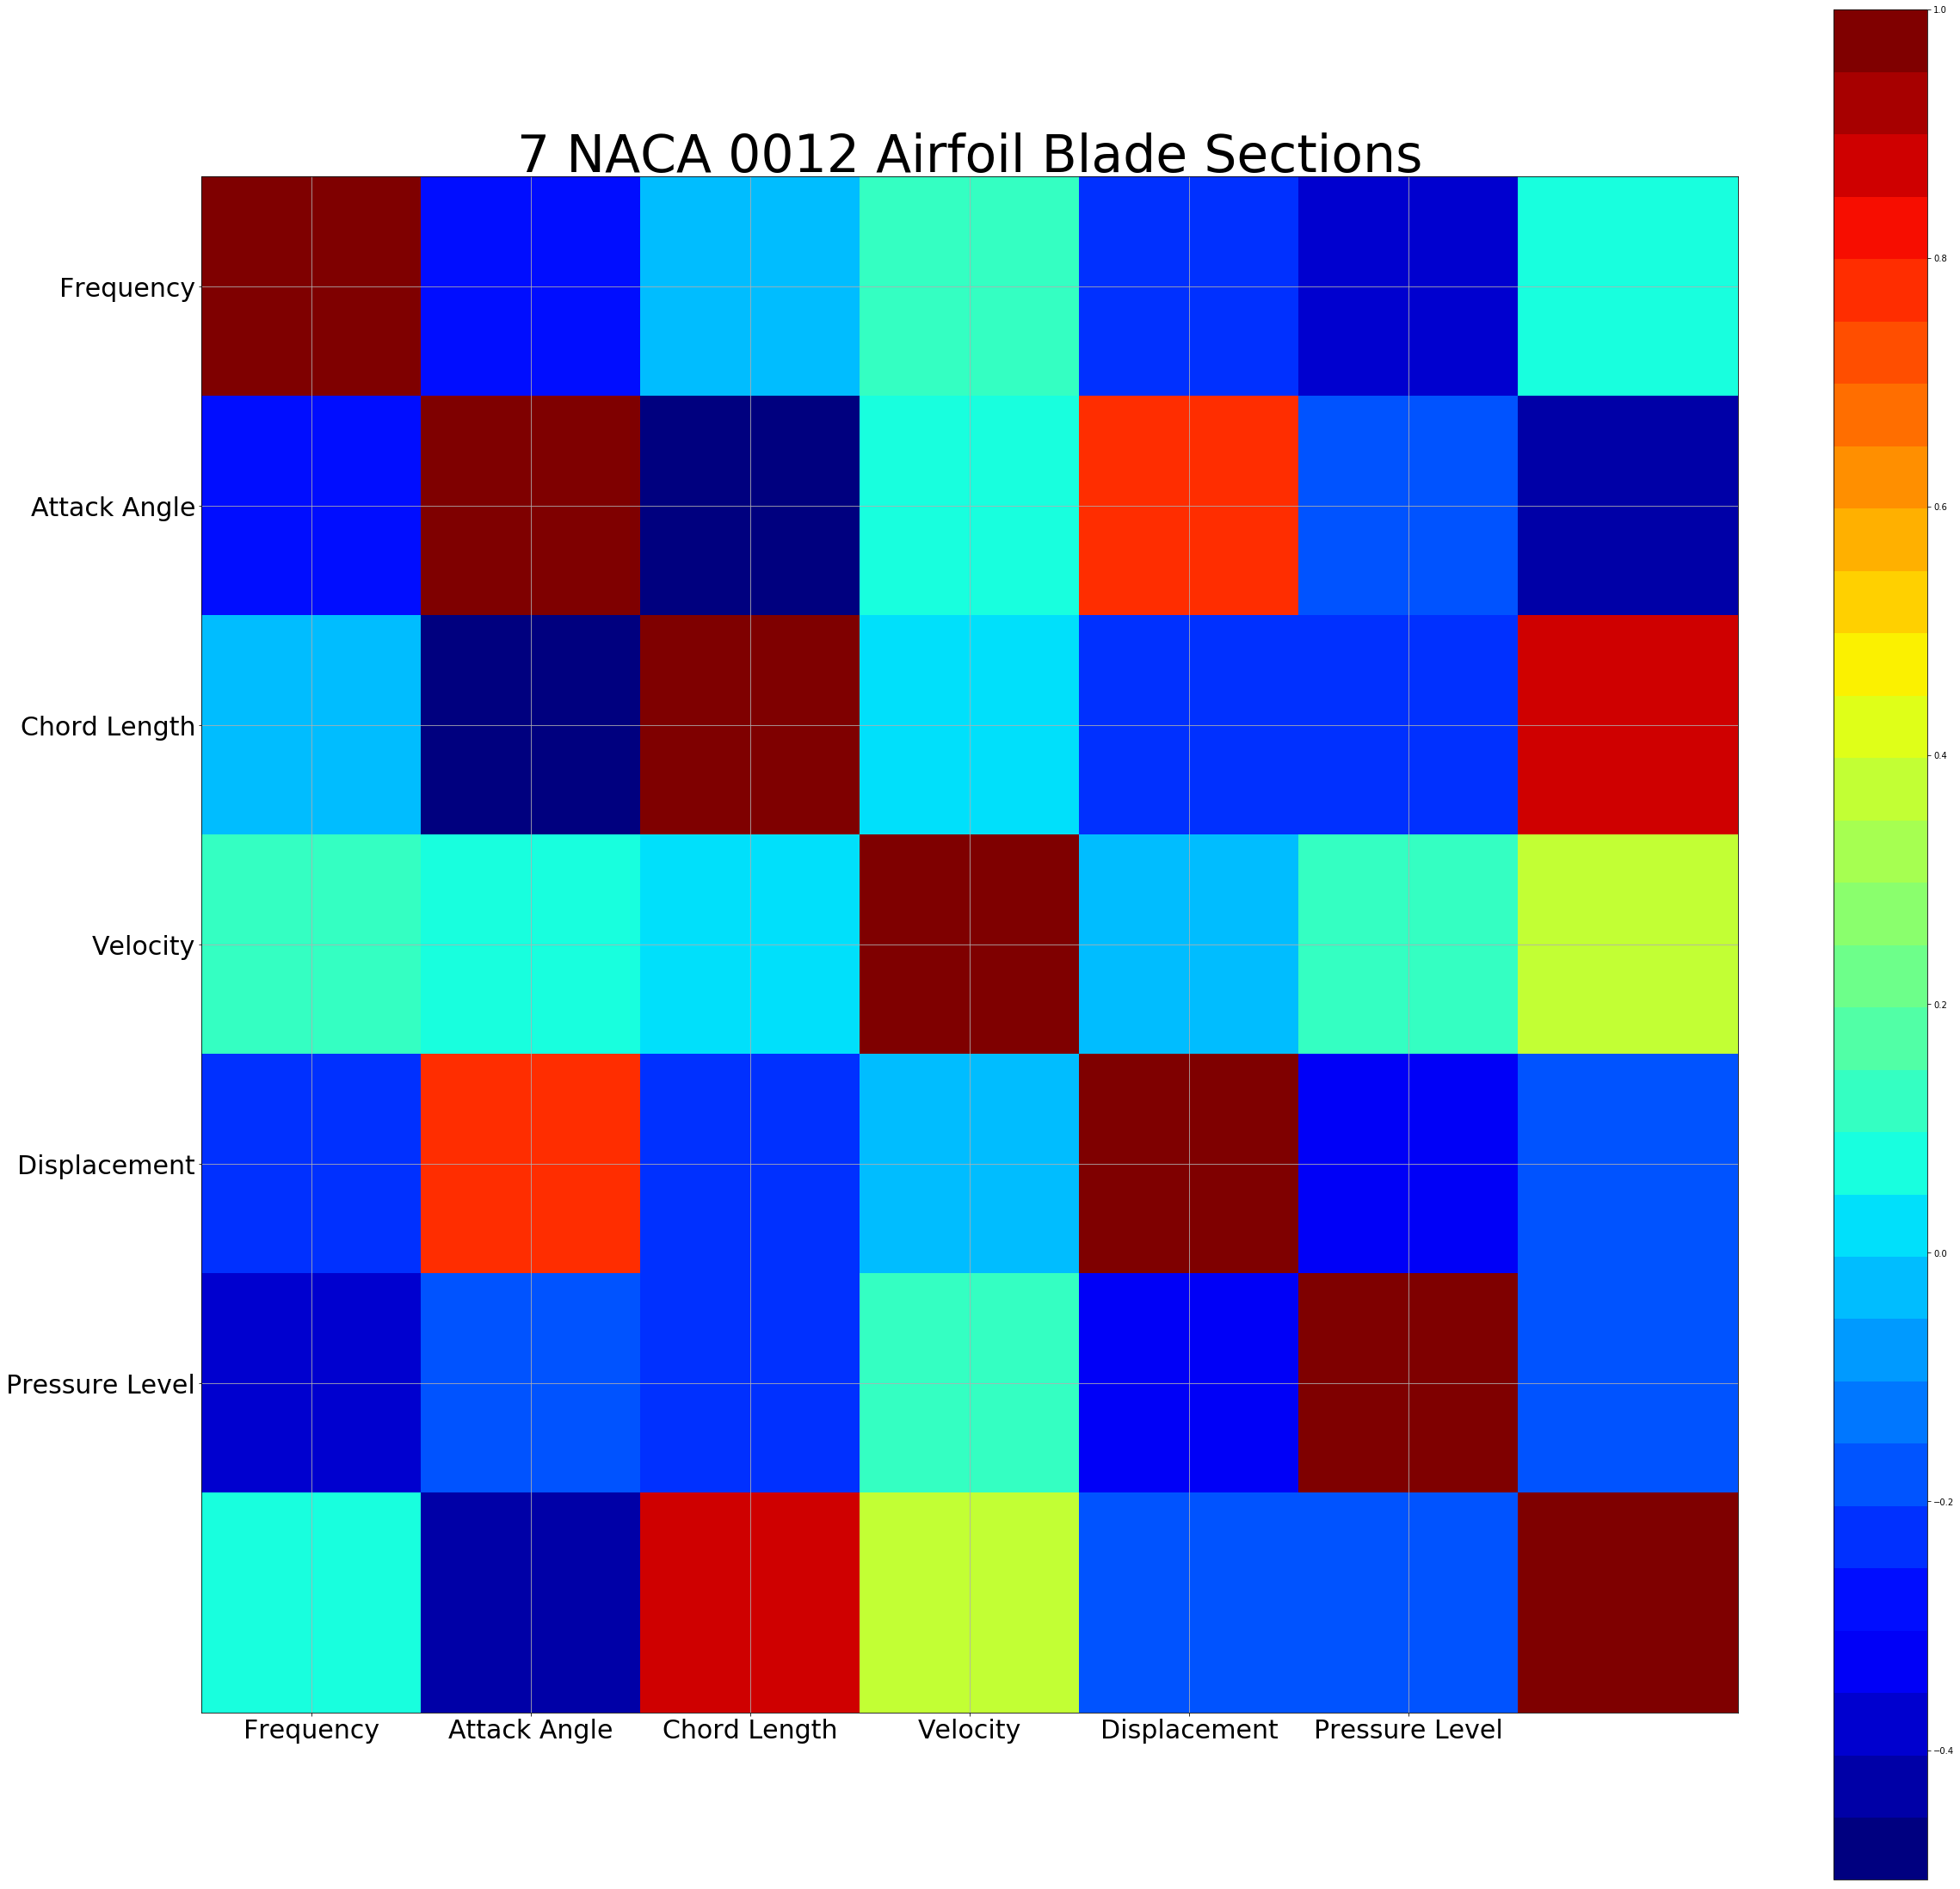

In [250]:
names = ['Frequency', 'Attack Angle', 'Chord Length','Velocity', 'Displacement', 'Pressure Level']

correlations = df.corr()
fig = plt.figure(figsize = (40,40))
ax = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
ax.grid(True)
plt.title('7 NACA 0012 Airfoil Blade Sections', fontsize = 60)
cax = ax.imshow(correlations, interpolation = 'nearest', cmap = cmap)
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, fontsize = 30);
ax.set_yticklabels(names, fontsize = 30);

## Formulating a hypothesis

In this case we test a simple hypothesis, that the relationship between the thickness of the airfoil shape is related to noise level. Is this relationship significant? The Pearson correlation function from scipy stats performs a test and returns a p-value. Interpret the p-value.

#### Is there a relationship between thickness and noise level signficant?
Visualize this relationship if you so wish.

In [252]:
thickness = df['Displacement'].astype(float)
noise_level = df['Sound Pressure Level'].astype(float)

In [253]:
import scipy.stats as stats

In [255]:
stats.ttest_ind(thickness, noise_level)

Ttest_indResult(statistic=-701.0167585389426, pvalue=0.0)

<b>The results of the test suggest the groups dont have the same sample means.
The $\ p = 0.0$, which is lower than the $\alpha = 0.05$. We reject the null hypothesis for alternative hypothesis. This means there is no relationship
between thichness and noise_level

## Regression

Implement a multiple regression model to determine the target variable using the given predictor variables, namely, the noise level.